# Calcul de gradients avec Autograd
____

Dans ce cours, nous allons apprendre à utiliser le package Autograd de PyTorch pour calculer les gradients.

Les gradients sont essentiels pour l'optimisation de notre modèle, c'est un concept vraiment important que nous devons comprendre. Heureusement, PyTorch nous propose le package Autograd qui nous permet d'effectuer tous les calculs pour nous, nous avons donc juste à savoir comment l'utiliser. C'est parti !

Tout d'abord, nous devons importer PyTorch.

In [1]:
import torch

Créons maintenant un tenseur x, et supposons que plus tard, nous devons calculer le gradient des fonctions associées à x. Spécifions donc à PyTorch de calculer le gradient du tenseur :

In [2]:
x = torch.rand(3, requires_grad=True)
x

tensor([0.5946, 0.6039, 0.0906], requires_grad=True)

Maintenant, à chaque fois que nous réaliserons une opération ou une fonction associé à ce tenseur, PyTorch va tracer un graphe de calcul, par exemple "y = x + 2" : 

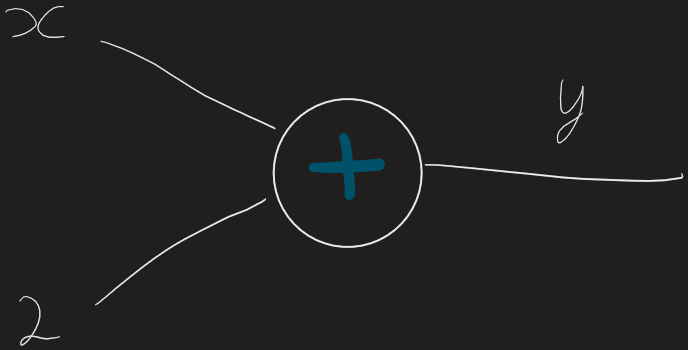

A l'aide de la technique de rétropropagation sur ce graphe, PyTorch va donc calculer le gradient de chaque noeud (je présume que vous connaissez le concept de rétropropagation, sinon j'en parlerais plus en détail au prochain cours. Pour l'instant, juste savoir comment l'utiliser est suffisant).

En première étape, on effectue une lecture avant du graphe (on applique juste l'opération _y = x + 2_), et si on a précisé qu'on voulait calculer le gradient, PyTorch crée et stocke automatiquement une fonction utilisée dans la rétropropagation pour obtenir le gradient. Donc y va avoir un attribut "_grad_fm_" qui pointe vers la fonction de calcul (que l'on appelera ici "__Add Backward__" car c'est une addition) et avec cette fonction, nous pouvons calculer le gradient de y associé à x :

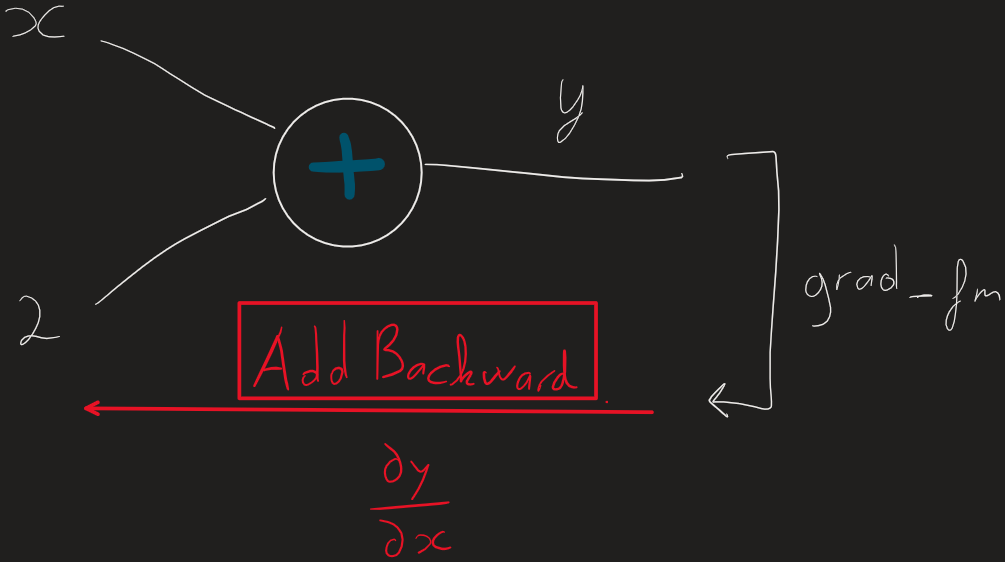

Si nous effectuons ce calcul :

In [3]:
y = x + 2
y

tensor([2.5946, 2.6039, 2.0906], grad_fn=<AddBackward0>)

On peut donc voir l'attribut grad_fn associé à la fonction __AddBackward0__, ce qui est logique car on effectue une addition. 

Faisons d'autres opérations avec notre tenseur :

In [4]:
z = y*y*2
z

tensor([13.4638, 13.5604,  8.7414], grad_fn=<MulBackward0>)

In [5]:
z = z.mean()
z

tensor(11.9219, grad_fn=<MeanBackward0>)

Si nous voulons calculer les gradients, la seule chose à faire est d'utiliser la fonction ___backward()___ :

In [6]:
z.backward() # dz/dx

In [7]:
x.grad

tensor([3.4595, 3.4718, 2.7875])

Nous avons maintenant le gradient de ce tenseur. 

Maintenant, regardons ce qu'il se passe si on ne spécifie pas l'argument "_requires_grad=True_" :

In [8]:
x = torch.rand(5)
y = x+2
z = y*y*2
c = z.mean()
x,y,z,c

(tensor([0.4501, 0.1268, 0.0021, 0.9980, 0.5321]),
 tensor([2.4501, 2.1268, 2.0021, 2.9980, 2.5321]),
 tensor([12.0058,  9.0469,  8.0167, 17.9755, 12.8232]),
 tensor(11.9736))

On remarque tout d'abord que nous n'avons pas l'attribut "_grad_fn_" sur les tenseurs. Et si on tente de faire la rétropropagation :

In [9]:
c.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

On obtient une erreur car nous n'avons pas de fonction de gradient. Une autre chose que l'on doit savoir c'est qu'en arrière-plan, PyTorch effectue le calcul du produit jacobien du gradient précédent pour trouver le gradient suivant (on ne rentrera pas dans les détails mathématiques) pour chaque opération : c'est aussi appelé la règle de la chaine, nous en parlerons plus en détail au prochain cours.

Ce qu'il faut noter, c'est que la matrice jacobienne est multipliée par un vecteur de la même taille. 

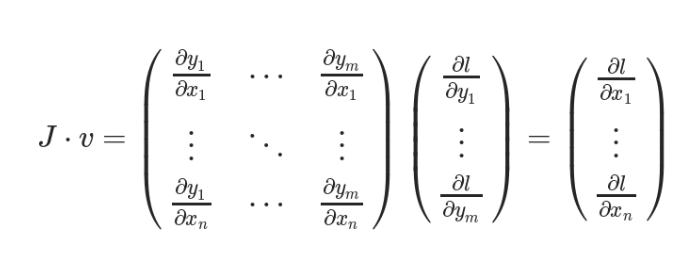

Dans l'exemple précédent, z est un scalaire, il n'y a pas besoin d'utiliser d'argument à la fonction _backward()_. Mais si on retire la dernière opération (qui est l'opération de moyenne), voici ce que l'on obtient :

In [10]:
x = torch.rand(3, requires_grad=True)
y = x+2
z = y*y*2
z.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

Dans ce cas-là, nous devons donner un argument, pour cela, nous créons un vecteur de la même taille que nous donnons ensuite comme argument pour _backward()_:

In [11]:
v = torch.tensor([0.1, 1.0, 0.01], dtype=torch.float32)
z.backward(v)
x.grad

tensor([ 0.8163, 10.7275,  0.1156])

Vous devez donc noter qu'il faut toujours mettre en argument de backward un tenseur de la même taille que le tenseur de départ. Notez par ailleurs que la plupart du temps, la dernière opération effectuée doit créer une valeur scalaire afin d'éviter de mettre un argument. 

Une autre chose à savoir est comment empêcher PyTorch de suivre l'historique et de calculer cet attribut '_grad_fn_'. Par exemple, lors des boucles d'apprentissage, lorsque l'on veut mettre à jour nos poids, cette opération ne doit pas faire partie du calcul du gradient (on donnera un exemple concret par la suite). 

Nous avons 3 options pour ça :
    
    - x.requires_grad_(False)
    
    - x.detach() : créer un nouveau tenseur qui n'a pas besoin du gradient
   
    - Envelopper la boucle avec une déclaration "with":
        with torch.no_grad():
            ...
        end

Une dernière chose importante à savoir est qu'au moment où on appelle la fonction _backward()_, le gradient de ce tenseur sera accumulé dans l'attribut "_.grad_". Leurs valeurs seront donc accumulées. Faisons donc un modèle d'entrainement pour le montrer :

In [12]:
weights = torch.ones(4, requires_grad=True)

for epoch in range(4):
    model_output = (weights*3).sum()
    model_output.backward()
    print(weights.grad)

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])
tensor([12., 12., 12., 12.])


A cause de l'accumulation, nos gradients sont incorrects, donc il faut effacer nos gradients.

In [13]:
weights = torch.ones(4, requires_grad=True)

for epoch in range(4):
    model_output = (weights*3).sum()
    model_output.backward()
    print(weights.grad)
    weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])


C'est une chose importante à noter durant la boucle d'apprentissage et plus tard, nous allons travailler avec l'**optimiseur intégré de PyTorch**, qui fait exactement la même chose.

In [14]:
optimizer = torch.optim.SGD([weights], lr=0.01)
optimizer.step()
optimizer.zero_grad()

____________________________________________________________________________________________________________________________________________________________________________________________________________

Ce cours sur le calcul de gradient est maintenant terminé, merci à vous d'avoir lu jusqu'au bout et on se retrouve sur le prochain cours : la rétropropagation, théorie et exemple !